<H1>TROPOMI Ozone Profile retrievals</H1>

Authors: Henk Eskes, Serena Di Pede, Felipe Cifuentes <br>
Contact: henk.eskes@knmi.nl <br>
September 2024

In this notebook we will explore the TROPOMI ozone profile product. <br>
This is an optimal estimation retrieval following the theory described in the book of Rodgers, 2000. <br>
The product includes an ozone profile, the averaging kernel and the error covariance matrix, and the a-priori profile.

All TROPOMI operational products come with three documents:<br>
1. The Product Readme File (PRF): This provides an overview of code changes and versions and some high level recommendations for use.<br>
2. The Product User Manual (PUM): Describing the fields in the data file and data use.<br>
3. The Algorithm Theoretical Baseline Document (ATBD): Describing the retrieval algorithm in detail.

These documents are provided by Copernicus/ESA on the Sentinel-5P Document Library page:<br>
https://sentiwiki.copernicus.eu/web/s5p-products

The ozone profile retrieval and validation of the product are described in a recent paper:<br>
Arno Keppens, Serena Di Pede et al., <br>
<i>5 years of Sentinel-5P TROPOMI operational ozone profiling and 
geophysical validation using ozonesonde and lidar ground-based networks </i><br>
https://doi.org/10.5194/amt-17-3969-2024

In the subroutine "read_single_profile" we open the ozone retrieval file and read one profile, <br>
for a specified scanline i_t (along-track index) and viewing angle (i_x, across-track index).

The routine reads the most relevant variables from the file. 
The ozone profile is then converted to ozone density, unit molecules per centimeter cube, but is also available in Dobson Units.

Exercise: Go through the routine and try to understand the meaning of the fields that are read from the file, and why they are relevant.

We also introduce the routines to do the plotting.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
def read_single_profile(file_name, i_t, i_x):

    """
    This function reads one single profile from the netCDF4 file of the ozone profile
    at the row i_x, scanline i_t.

    It returns the result of the reading as a dictionary.

    Ozone profiles are in molec. cm-3, while columns are in Dobson units,
    altitude in km and pressure in hPa.
    """

    # print('\n-------------------------------------------------------------------------------------------------')
    print('reading', file_name)

    res={} # define output struct

    with nc.Dataset(file_name) as f:

        time_epoch = np.datetime64('T'.join(f['/PRODUCT/delta_time'].units.split(' ')[-2:]))
        delta_time = np.array( f['PRODUCT/delta_time'][0,:], dtype='timedelta64[ms]')

        res['datetime'] = time_epoch + delta_time

        res['alt'] = f['/PRODUCT/altitude'][0,i_t,i_x,:] * 1e-3 # altitude in km
        res['pressure'] = f['/PRODUCT/pressure'][0,i_t,i_x,:] * 1e-2 # air pressure converted in hPa
        res['temperature'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/temperature'][0,i_t,i_x,:]
        res['tropopause_temp'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/temperature_at_tropopause'][0,i_t,i_x]
        res['tropopause_pres'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/pressure_at_tropopause'][0,i_t,i_x] * 1e-2 # pressure in hPa
        
        conversion_to_molcm3 = (f['/PRODUCT/ozone_profile']).getncattr('multiplication_factor_to_convert_to_molecules_percm3')
        conversion_to_molcm2 = (f['/PRODUCT/ozone_total_column']).getncattr('multiplication_factor_to_convert_to_molecules_percm2')
        conversion_to_molcm6 = (f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/ozone_profile_error_covariance_matrix']).getncattr('multiplication_factor_to_convert_to_molecules2_percm6')
        conversion_to_du = 2241.15
        
        res['o3_ndens'] = f['/PRODUCT/ozone_profile'][0,i_t,i_x,:] * conversion_to_molcm3
        res['o3_ndens_prec'] = f['/PRODUCT/ozone_profile_precision'][0,i_t,i_x,:] * conversion_to_molcm3 # noise error
        res['o3_ndens_smooth'] = f['/PRODUCT/ozone_profile_smoothing'][0,i_t,i_x,:] * conversion_to_molcm3
        res['o3_ndens_ak'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/averaging_kernel'][0,i_t,i_x,:,:]
        res['o3_cov_matrix'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/ozone_profile_error_covariance_matrix'][0,i_t,i_x,:,:]*conversion_to_molcm6        
        res['to3'] = f['/PRODUCT/ozone_total_column'][0,i_t,i_x] * conversion_to_du
        res['to3_prec'] = f['/PRODUCT/ozone_total_column_precision'][0,i_t,i_x] * conversion_to_du
        res['tropo3'] = f['/PRODUCT/ozone_tropospheric_column'][0,i_t,i_x] * conversion_to_du
        res['tropo3_prec'] = f['/PRODUCT/ozone_tropospheric_column_precision'][0,i_t,i_x] * conversion_to_du

        res['o3_subc'] = f['/PRODUCT/ozone_profile_subcolumns'][0,i_t,i_x,:] * conversion_to_du
        res['o3_subc_prec'] = f['/PRODUCT/ozone_profile_subcolumns_precision'][0,i_t,i_x,:] * conversion_to_du

        res['o3_ndens_ap'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/ozone_profile_apriori'][0,i_t,i_x,:] * conversion_to_molcm3
        res['o3_ndens_ap_prec'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/ozone_profile_apriori_precision'][0,i_t,i_x,:] * conversion_to_molcm3
        res['to3_ap'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/ozone_total_column_apriori'][0,i_t,i_x] * conversion_to_molcm2 # atmosphere_mole_content_of_ozone
        res['refl330nm'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/reflectance_at_330nm'][0,i_t,i_x] # TOA reflectance for cloud fraction determination

#         res['qa_value'] = int( 100 * f['/PRODUCT/qa_value'][0,i_t,i_x] + 0.5)
        res['qa_value'] = f['/PRODUCT/qa_value'][0,i_t,i_x]
    
        res['lat'] = f['/PRODUCT/latitude'][0,i_t,i_x]
        res['lon'] = f['/PRODUCT/longitude'][0,i_t,i_x]
        res['sza'] = f['/PRODUCT/SUPPORT_DATA/GEOLOCATIONS/solar_zenith_angle'][0,i_t,i_x]
        res['vcd'] = f['/PRODUCT/SUPPORT_DATA/GEOLOCATIONS/viewing_azimuth_angle'][0,i_t,i_x]
        res['vza'] = f['/PRODUCT/SUPPORT_DATA/GEOLOCATIONS/viewing_zenith_angle'][0,i_t,i_x]

        res['surface_albedo'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/surface_albedo'][0,i_t,i_x]
        res['cloudfrac'] = f['/PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_fraction_crb_ozone_window'][0,i_t,i_x]

        res['dfs'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/degrees_of_freedom_ozone'][0,i_t,i_x]
        res['conv_status'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/convergence_status'][0,i_t,i_x]
        res['rms_fit'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/root_mean_square_error_of_fit'][0,i_t,i_x]
        res['costf'] = f['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/cost_function'][0,i_t,i_x]

    return res

def plot_pixel(o3pr_data, orbit, it, ix):
    
    """
    This function plots the ozone profile, a-priori profile and relative errors.

    You need to provide the dictionary of the data,
    the orbit, row and scanline.
    """
    
    fix,axs=plt.subplots(nrows=1, ncols=2, figsize=(8,7))
    print('Position \n Lat: {:.2f}, lon: {:.2f}'.format(o3pr_data['lat'], o3pr_data['lon']))
    plt.suptitle('Orbit {}, scanline={}, row={}, \n quality={}, DFS={:.1f}, TOZ = {:.1f} DU \n surface albedo={:.2f}, cloud fraction={:.1f}'.format(orbit, it, ix, o3pr_data['qa_value'], o3pr_data['dfs'], o3pr_data['to3'], o3pr_data['surface_albedo'][2], o3pr_data['cloudfrac']))
    
    axs[0].plot(o3pr_data['o3_ndens'][:26]*1e-12, o3pr_data['alt'][:26],'o-', ms=4, lw=2, markerfacecolor='w', color='royalblue',label='retrieval')
    axs[0].plot(o3pr_data['o3_ndens_ap'][:26]*1e-12, o3pr_data['alt'][:26],'k-', lw=2, alpha=0.75,label='a-priori')
    axs[0].set_ylim(0,53)
    axs[0].legend()
    axs[0].grid(color = 'gray', linestyle = '--', linewidth=0.3)
    axs[0].set_xlabel('Number Density [10¹² molec. cm⁻³]',fontsize=12)
    ## Compute errors

    error = np.sqrt( o3pr_data['o3_ndens_smooth']**2 + o3pr_high['o3_ndens_prec']**2 )
    val_m_error = (o3pr_data['o3_ndens'] - error )*1e-12
    val_p_error = (o3pr_data['o3_ndens'] + error )*1e-12
    
    axs[1].fill_betweenx(o3pr_data['alt'][:26]*1e-3, val_m_error[:26], val_p_error[:26], color='gray', alpha=0.50 )
    axs[1].plot( 100*(o3pr_data['o3_ndens'][:26]/o3pr_data['o3_ndens_ap'][:26]-1), o3pr_low['alt'][:26], color='k', lw=2,label='Rel diff retrieval/apriori/')
    axs[1].fill_betweenx(o3pr_data['alt'][:26], -o3pr_data['perc_o3_ndens_ap_prec'][:26], o3pr_data['perc_o3_ndens_ap_prec'][:26], color='gray', alpha=0.75,label= 'apriori error')
    axs[1].fill_betweenx(o3pr_data['alt'][:26], -o3pr_data['perc_o3_ndens_tot'][:26], o3pr_data['perc_o3_ndens_tot'][:26], color='lightgray', alpha=0.75 ,label='smooth+noise errors' )
    axs[1].fill_betweenx(o3pr_data['alt'][:26], -o3pr_data['perc_o3_ndens_prec'][:26], o3pr_data['perc_o3_ndens_prec'][:26], color='lightcoral', alpha=0.2,label='noise error')
    axs[1].grid(color = 'gray', linestyle = '--', linewidth=0.3)
    axs[1].set_ylim(0,53)
    axs[1].legend(loc='upper right',fontsize=8)
    axs[1].set_xlabel('Error and Difference [%]',fontsize=12)
    plt.show() 

def plot_ak(o3pr_data, orbit, it, ix):
    
    colors = plt.cm.jet(np.linspace(0,1,33))
    fix,axs=plt.subplots(nrows=1,ncols=2,figsize=(9,6))
    plt.suptitle('Orbit {}, scanline={}, row={}, \n quality={}, DFS={:.1f}, TOZ = {:.1f} DU \n surface albedo={:.2f}, cloud fraction={:.1f}'.format(orbit, it, ix, o3pr_data['qa_value'], o3pr_data['dfs'], o3pr_data['to3'], o3pr_data['surface_albedo'][2], o3pr_data['cloudfrac']))

    for lev in range(0,30,5):
        alt=o3pr_data['alt'][lev]
        axs[0].plot(o3pr_data['o3_ndens_ak'][lev, :26],o3pr_data['alt'][:26],label='lev={}, h={:.1f}km'.format(lev,alt),color=colors[lev])
    axs[0].grid(color = 'gray', linestyle = '--', linewidth=0.3,which='both',)
    axs[0].set_xlim(-1,1)
    axs[0].set_ylabel('Altitude [km]',fontsize=10)
    axs[0].tick_params(axis='both', which='major', labelsize=10)    
    axs[0].set_xlabel('AK [-]',fontsize=10)
    axs[0].legend()
    
    for lev in range(0,30,5):
        axs[1].semilogy(o3pr_data['o3_ndens_ak'][lev, :26],o3pr_data['pressure'][:26],color=colors[lev])
    axs[1].grid(color = 'gray', linestyle = '--', linewidth=0.3,which='both')
    axs[1].set_xlim(-1,1)
    axs[1].invert_yaxis()
    axs[1].set_ylabel('Pressure [hPa]',fontsize=10)
    axs[1].tick_params(axis='both', which='major', labelsize=10)    
    axs[1].set_xlabel('AK [-]',fontsize=10)
    # plt.savefig('./avk_o3pr.png',facecolor='white',dpi=100)
    plt.show()    

def plot_sens_dof(o3pr_data, orbit, it, ix):

    rows_sensitivity=np.sum(o3pr_data['o3_ndens_ak'],axis=1)
    diag_ak=np.diag(o3pr_data['o3_ndens_ak'])
    dof_profile=np.trace(o3pr_data['o3_ndens_ak'])
    
    print('The total profile number of DOF is {:.2f}.'.format(dof_profile))
    
    colors = plt.cm.jet(np.linspace(0,1,33))
    fix,axs=plt.subplots(nrows=1,ncols=2,figsize=(9,8))
    plt.suptitle('Orbit {}, scanline={}, row={}, \n quality={}, DFS={:.1f}, TOZ = {:.1f} DU \n surface albedo={:.2f}, cloud fraction={:.1f}'.format(orbit, it, ix, o3pr_data['qa_value'], o3pr_data['dfs'], o3pr_data['to3'], o3pr_data['surface_albedo'][2], o3pr_data['cloudfrac']))
    axs[0].plot(rows_sensitivity[:26],o3pr_data['alt'][:26], color='royalblue', marker='s',markersize=4)
    axs[0].grid(color = 'gray', linestyle = '--', linewidth=0.3,which='both',)
    axs[0].set_ylabel('Altitude [km]',fontsize=10)
    axs[0].tick_params(axis='both', which='major', labelsize=10)    
    axs[0].set_title('AK Rows sensitivity')
    
    axs[1].plot(diag_ak[:26],o3pr_data['alt'][:26], color='royalblue', marker='s',markersize=4, label='Total DOF: {:.2f}'.format(dof_profile))
    axs[1].grid(color = 'gray', linestyle = '--', linewidth=0.3,which='both')
    axs[1].set_ylabel('Altitude [km]',fontsize=10)
    axs[1].tick_params(axis='both', which='major', labelsize=10)    
    axs[1].legend()
    axs[1].set_title('AK diagonal')
    
    plt.show()  

In [3]:
file_name='./data_O3/S5P_NRTI_L2__O3__PR_20240314T110748_20240314T111248_33256_03_020600_20240314T115305.nc'
orbit='33256'

The first two timestamps in the file name are the timerange of the data. As you can see, the granule file stores about 5 minutes of TROPOMI data. The last time stamp is the processing time. It is clear the processing was done in real time! The file name also contains the orbit number (33256) and processor version (02.06.00).

This granule was chosen because it contains substantial gradients in ozone. These are reflecting the dynamical flow in the atmosphere, and especially in spring we observe these gradients over northern midlatitudes. You will look at one pixel (ozone profile) with a high ozone column, and one with a low column within the granule.

In [4]:

### Select one pixel over an area where we measure a high total column ozone concentration
it_high=16
ix_high=30
o3pr_high=read_single_profile(file_name, it_high, ix_high)

### Select one pixel over an area where we measure a (relatively) low total column ozone concentration
it_low=51
ix_low=5
o3pr_low=read_single_profile(file_name, it_low, ix_low)


reading ./data_O3/S5P_NRTI_L2__O3__PR_20240314T110748_20240314T111248_33256_03_020600_20240314T115305.nc
reading ./data_O3/S5P_NRTI_L2__O3__PR_20240314T110748_20240314T111248_33256_03_020600_20240314T115305.nc


In [5]:
############
# This cell plots on the map the position of the two analysed pixels 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

latitude_low = o3pr_low['lat']
longitude_low = o3pr_low['lon'] 
latitude_high = o3pr_high['lat']
longitude_high = o3pr_high['lon'] 

# print("Location of the low ozone measurement:  lon = ",longitude_low, ", lat = ", latitude_low)
# print("Location of the high ozone measurement: lon = ",longitude_high, ", lat = ", latitude_high)

ax = world.plot(figsize=(10, 6))
plt.scatter(x=longitude_low, y=latitude_low, color='black', s=10, label="Low ozone column")
plt.scatter(x=longitude_high, y=latitude_high, color='red', s=10, label="High ozone column")

plt.title("Point on World Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

The precision (noise error) and smoothing error of the retrieval, and the assumed error on the a-priori are provided in absolute terms. Here we convert these errors into relative errors. 

In [6]:
# Calculate relative errors, as percentage
o3pr_low['perc_o3_ndens_prec'] = o3pr_low['o3_ndens_prec'] / o3pr_low['o3_ndens'] * 100.
o3pr_low['perc_o3_ndens_smooth'] = o3pr_low['o3_ndens_smooth'] / o3pr_low['o3_ndens'] * 100.
o3pr_low['perc_o3_ndens_ap_prec'] = o3pr_low['o3_ndens_ap_prec'] / o3pr_low['o3_ndens_ap'] * 100.
o3pr_low['perc_o3_ndens_tot'] = (o3pr_low['o3_ndens_prec'] + o3pr_low['o3_ndens_smooth']) / o3pr_low['o3_ndens'] * 100.

o3pr_high['perc_o3_ndens_prec'] = o3pr_high['o3_ndens_prec'] / o3pr_high['o3_ndens'] * 100.
o3pr_high['perc_o3_ndens_smooth'] = o3pr_high['o3_ndens_smooth'] / o3pr_high['o3_ndens'] * 100.
o3pr_high['perc_o3_ndens_ap_prec'] = o3pr_high['o3_ndens_ap_prec'] / o3pr_high['o3_ndens_ap'] * 100.
o3pr_high['perc_o3_ndens_tot'] = (o3pr_high['o3_ndens_prec'] + o3pr_high['o3_ndens_smooth']) / o3pr_high['o3_ndens'] * 100.

<h3>Plot the profile and the relative uncertainties</h3>


Position 
 Lat: 51.44, lon: 5.39


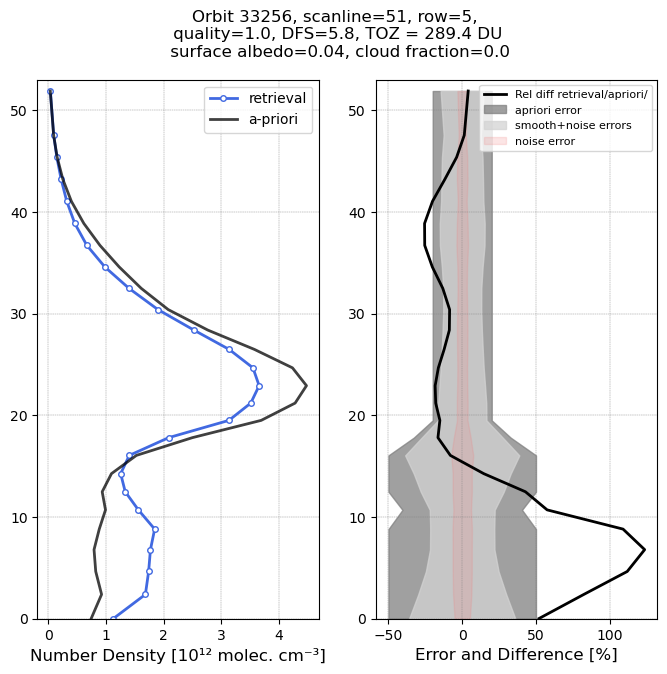

In [7]:
plot_pixel(o3pr_low, orbit, it_low, ix_low)

<h4>Low ozone column case</h4>

The low ozone profile shows ozone densities which are substantially reduced compared to the a-priori profile (black) around the ozone maximum, but enhanced in the free troposphere. 

Note the text above the plot which contains important information:

- Each TROPOMI retrieval comes with a "qa_value". Before using the data it is important to remove data with a low qa_value. According to the Product Readme File pixels with a qa_value ≦ 0.5 should not be used, and measurements for which the qa_value ≦ 0.8 should
be used with care. In this case the qa_value = 1, so no warnings or issues arose during the retrieval.

- By integrating the vertical profile we obtain a total ozone column. This is 289.4 Dobson Units for this profile.

- It is a clear-sky footprint with a relatively low surface albedo of 0.04.

- The DFS is the computed "Degrees of Freedom of Signal" (see Rodgers, 2000). For this retrieval this is 5.8. It indicates that the retrieval extracted close to 6 independent pieces of information. Roughly speaking, the retrieval is able to determine mean ozone amounts for layers of about 8 km thick.

The error plot shows the assumed uncertainty in the a-priori profile shape (20% in the stratosphere, 50% in the troposphere). The noise error in the retrieval is much smaller, showing that the mean concentrations are well constrained. 

The plot also shows the smoothing error. This reflects estimated differences between high-resolution actual ozone profiles and the smoothed 8-km resolution retrieved profiles. This smoothing error is much larger than the noise error. See Rodgers, 2000, for more detail.


Position 
 Lat: 47.91, lon: 22.29


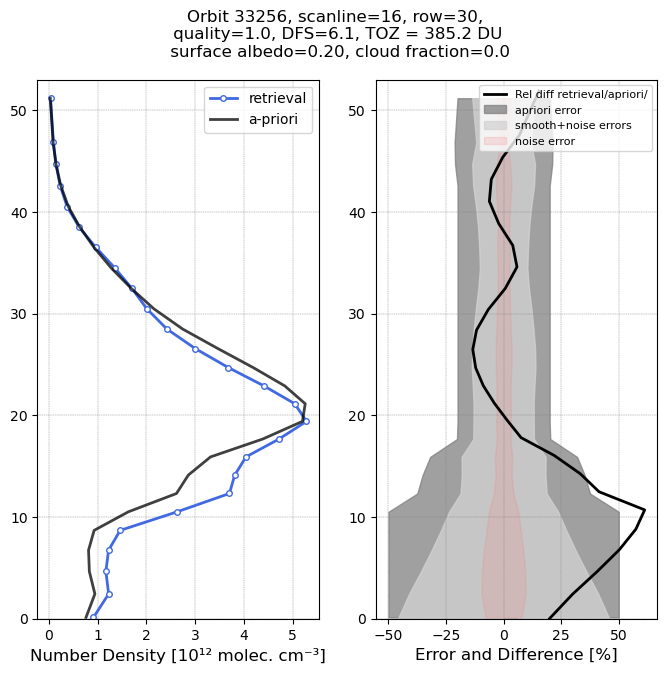

In [8]:
plot_pixel(o3pr_high, orbit, it_high, ix_high)

The high ozone case shows significantly enhanced ozone values in the 10-20 km range, compared to the a-priori profile. Total ozone is now 385.2 DU, about 100 DU larger that the low column case. The surface albedo is higher, and the DFS is also a bit higher, around 6.1.

<h3>Averaging Kernel Analysis </h3>

We visualise the Averaging Kernel (AK) matrix by plotting the columns of the matrix (density of the AK) for levels 0, 5, .. 25 Level 0 is the surface level. Above level 25 (higher stratosphere, mesosphere) the retrieval becomes more uncertain.

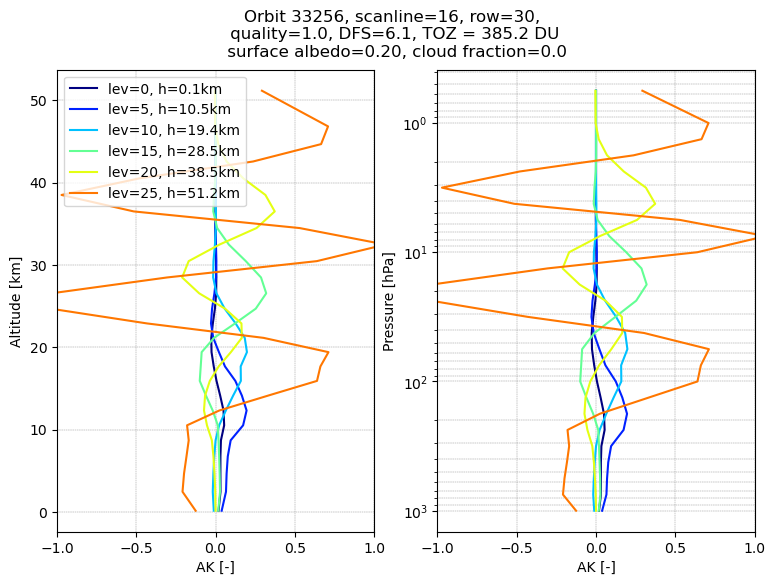

In [9]:
plot_ak(o3pr_high,orbit, it_high, ix_high)

The AK profiles for levels in the range between about 10 and 40 km altitude (levels 5, 10, 15, 20) show a peak value in the level for which the column was extracted (e.g. the green curve peaks close to 28 km altitude). This indicates that the TROPOMI spectrum contains ozone information at this level. The width of the AK gives an impression of the vertical resolution (of the order of 5-10 km in this 10-40 km range). 

Question: Note that the kernels also show negative values. What does this mean?

The spectrum contains very little ozone information for levels close to the surface and at the higher stratospheric altitudes above 40 km. <br>
At the surface the kernel values become very small, and the kernel does no longer have it's peak at the level 0 altitude.<br>
For the highest levels the kernels start to show strong oscillations over the whole stratospheric range.

Exercise: plot also the averaging kernels for the low ozone case, and for other levels. Are there major differences?

<h3>Level sensitivity and DOF</h3>

The averaging kernel (AK) matrix contains other interesting information (Rodgers, 2000).

The <b>AK row sum</b> give the level sensitivity, how much information comes from the measurement or a-priori. If the sensitivity is equal to 1, it means that the information at that level comes from the measurement, while (1-row_sensitivity) comes from the a-priori.

The <b>diagonal elements of the AK matrix</b> gives the amount of information from each specific level. <br> 
The trace of the AK matrix, or the sum over the layers, is the total degrees of freedom for signal. 


The total profile number of DOF is 5.97.


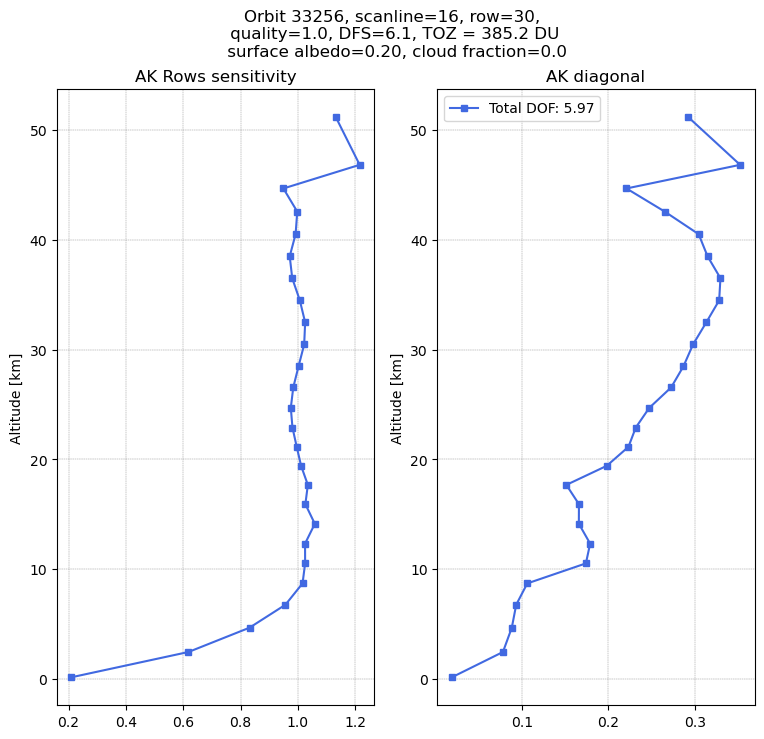

In [10]:
# plot_sens_dof(o3pr_low,orbit, it_low, ix_low)
plot_sens_dof(o3pr_high, orbit, it_high, ix_high)

In the range 10-40 km the row sensitivity is close to 1, showing the retrieved profile is well constrained by the TROPOMI data. In the lower troposphere this sensitivity is strongly reduced. At the surface the profile moves towards the a-priori value. 

In the range 10-40 km we have to sum up 3-5 layers to obtain one piece of information (corresponding to 5-10 km layers).<br>
The sum of the diagonal AK elements is close to the reported DFS = 6.1 (which is computed in a slightly different way in the retrieval code).

<h3>Comparison with CAMS forecasts</h3>

We start by importing some extra packages:

In [11]:
import xarray as xr
from utils_o3 import *

We will now compare the retrieved profile with the CAMS forecast for the same date, time and location.

The ozone content of the file has been obtained from the CAMS ADS. We extracted the CAMS 12h ozone forecast starting from 0:00 on 14 March 2024.

This 12utc field is close to the overpass time of TROPOMI over Europe. As simplified "time interpolation" we just selected this one time to match the satellite time. 

In [12]:
cams_path = './data_O3/CAMS_O3_forecast_20240314_12utc.nc'


Note, however, that apart from the ozone data we also need information about the pressure levels (CAMS runs on 137 hybrid layers). But these are not provided by default by the CAMS ADS. What we need extra are:<br>
- The surface pressure. <br>
- The hybrid level coefficients A and B for the 137 layers. (Note that the A, B coefficients are static and have to be retrieved just once.)

With these we can compute the level pressure of layer <i>l</i> :<br>
p<sub>l</sub> = A<sub>l</sub> + B<sub>l</sub> p<sub>surf</sub>

Coefficient B = 1 and A = 0 at the surface. The lowest level follows the terrain and time-location dependent pressure at the surface.<br>
Coefficient B becomes 0 in the upper part of the atmosphere. Here the model levels become fixed pressure levels.

In the data file supplied with this notebook we have added the surface pressure and level coefficients to the ozone field extracted from the ADS.

Open the netCDF file with the 3D ozone field and extract needed variables: ozone, A, B, sp.

In [13]:
cams_glob = xr.open_dataset(cams_path)

Let's see what is in the file:

In [14]:
cams_glob

<xarray.Dataset> Size: 224MB
Dimensions:                   (time: 1, level: 137, lat: 451, lon: 900,
                               model_level_coefficients: 138)
Coordinates:
  * level                     (level) float64 1kB 1.0 2.0 3.0 ... 136.0 137.0
  * model_level_coefficients  (model_level_coefficients) int64 1kB 0 1 ... 137
  * lon                       (lon) float64 7kB 0.0 0.4 0.8 ... 359.2 359.6
  * lat                       (lat) float64 4kB 90.0 89.6 89.2 ... -89.6 -90.0
Dimensions without coordinates: time
Data variables:
    o3                        (time, level, lat, lon) float32 222MB ...
    sp                        (time, lat, lon) float32 2MB ...
    a                         (model_level_coefficients) float32 552B ...
    b                         (model_level_coefficients) float32 552B ...

Note that in CAMS the layers start at the top of the atmosphere, and the last layer is the surface layer.<br>
We used "flip" to reverse the order, so from now on the first layer is the surface layer.

In [15]:

lat = cams_glob.lat.values
lon = cams_glob.lon.values

cams_a = np.flip(cams_glob.a.values, axis=0)
cams_b = np.flip(cams_glob.b.values, axis=0)

sp = cams_glob.sp.values[0,:,:]                         # Units: ln [Pa]
o3_cams = np.flip(cams_glob.o3.values[0,:,:,:], axis=0) # Units: Kg/Kg


Next we compute the (three-dimensional) full level (centre of the layer) and half level (layer interfaces) pressures and altitudes for this CAMS field:

In [16]:
pres_fl, pres_hl = CAMS_level_pressures(o3_cams, sp, cams_a, cams_b)

#print ( pres_fl[:,0,0] )
#print ( pres_hl[:,0,0] )
#print ( sp[0,0] )
#print ( len(pres_fl[:,0,0]), len(pres_hl[:,0,0]) )

We now perform a horizontal interpolation to the two low and high ozone TROPOMI pixels. <br>
This is done by simply selecting the CAMS grid cell containing the centre of the TROPOMI pixel. <br> 

In [17]:
index_lat_low, index_lon_low = index_point(latitude_low,longitude_low,lat,lon)
index_lat_high, index_lon_high = index_point(latitude_high,longitude_high,lat,lon)

NameError: name 'latitude_low' is not defined

Let's check these indices

In [18]:
print ( "Low ozone CAMS grid cell  lat, lon = ", lat[index_lat_low],lon[index_lon_low] )
print ( "High ozone CAMS grid cell lat, lon = ", lat[index_lat_high],lon[index_lon_high] )

NameError: name 'index_lat_low' is not defined

Extract the CAMS ozone profile for the high and low ozone cases

In [19]:
o3_cams_low  = o3_cams[:,index_lat_low,index_lon_low]
o3_cams_high = o3_cams[:,index_lat_high,index_lon_high]

NameError: name 'index_lat_low' is not defined

Next step is the vertical interpolation. The 137 layer CAMS profile is interpolated to the TROPOMI retrieval layers. 

For simplicity we implemented a linear interpolation. 
(For quantitative comparisons a more advanced interpolation approach is adviced.)

In [20]:
# Extract CAMS pressure profiles in hPa at the two locations
pres_fl_low = pres_fl[:,index_lat_low,index_lon_low]*0.01
pres_fl_high = pres_fl[:,index_lat_high,index_lon_high]*0.01

o3_cams_low_interp  = cams_to_tropomi_linear(o3_cams_low[:], o3pr_low['o3_ndens'][:], pres_fl_low[:], o3pr_low['pressure'][:])
o3_cams_high_interp = cams_to_tropomi_linear(o3_cams_high[:], o3pr_high['o3_ndens'][:], pres_fl_high[:], o3pr_high['pressure'][:])

print ( "o3_cams_low:          nr of layers = ", len(o3_cams_low) )
print ( "o3_cams_low_interpol: nr of layers = ", len(o3_cams_low_interp) )

NameError: name 'index_lat_low' is not defined

Exercise: You can check if the simple interpolation is reasonable by plotting the two CAMS profiles together in a plot.

The CAMS ozone field is provided as mass mixing ratio (kg/kg).<br>
The TROPOMI ozone is a density profile (molecules per cm^3).

With the ideal gas law we can transform the CAMS mixing ratio to ozone densities:

In [21]:
o3dens_cams_low_interp = convert_o3_massmixing_to_molec_cm3 ( o3_cams_low_interp[:], o3pr_low['pressure'][:]*100.0, o3pr_low['temperature'][:])
o3dens_cams_high_interp = convert_o3_massmixing_to_molec_cm3 ( o3_cams_high_interp[:], o3pr_high['pressure'][:]*100.0, o3pr_high['temperature'][:])


NameError: name 'o3_cams_low_interp' is not defined

The last step is the application of the averaging kernels. <br>
The observation operator H to compare the CAMS profile <b>x</b> with the retrieved optimal estimation profile is:<br> 
H(<b>x</b>) = <b>x</b><sub>a</sub> + <b>A</b> ( <b>x</b> - <b>x</b><sub>a</sub>) <br>
where <b>x</b><sub>a</sub> is the TROPOMI a-priori profile (see Rodgers, 2000).

In [22]:
x_a_low = o3pr_low['o3_ndens_ap'][:]
x_low = o3dens_cams_low_interp[:]
A_low = o3pr_low['o3_ndens_ak'][:,:]

x_a_hi = o3pr_high['o3_ndens_ap'][:]
x_hi = o3dens_cams_high_interp[:]
A_hi = o3pr_high['o3_ndens_ak'][:,:]

NameError: name 'o3dens_cams_low_interp' is not defined

In [23]:
x_s_low = x_a_low + np.matmul(A_low, (x_low - x_a_low))
x_s_hi = x_a_hi + np.matmul(A_hi, (x_hi - x_a_hi))

NameError: name 'A_low' is not defined

Now we can present the comparison in a plot. 

NameError: name 'o3dens_cams_low_interp' is not defined

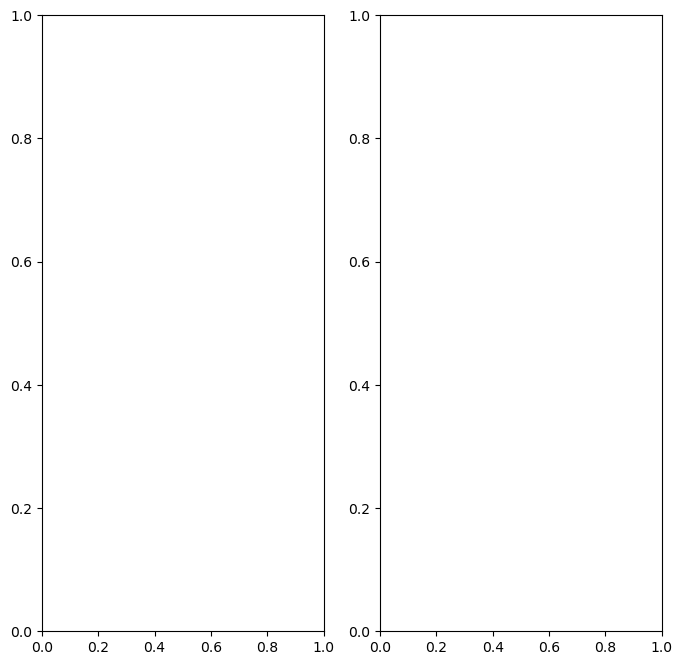

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8,8))

axs[0].semilogy(o3dens_cams_low_interp[:26]/1e12, o3pr_low['pressure'][:26], marker='.', label='CAMS', color='green')
axs[0].semilogy(x_s_low[:26]/1e12, o3pr_low['pressure'][:26], marker='.', label='CAMS - AKs', color='crimson')
axs[0].semilogy(o3pr_low['o3_ndens'][:26]*1e-12, o3pr_low['pressure'][:26], marker='x' ,label='TROPOMI', color='navy')
axs[0].semilogy(o3pr_low['o3_ndens_ap'][:26]*1e-12, o3pr_low['pressure'][:26], marker='x' ,label='TROPOMI apriori', color='grey')

axs[1].semilogy(o3dens_cams_high_interp[:26]/1e12, o3pr_high['pressure'][:26], marker='.', label='CAMS', color='green')
axs[1].semilogy(x_s_hi[:26]/1e12, o3pr_high['pressure'][:26], marker='.', label='CAMS - AKs', color='crimson')
axs[1].semilogy(o3pr_high['o3_ndens'][:26]*1e-12, o3pr_high['pressure'][:26], marker='x' ,label='TROPOMI', color='navy')
axs[1].semilogy(o3pr_high['o3_ndens_ap'][:26]*1e-12, o3pr_high['pressure'][:26], marker='x' ,label='TROPOMI apriori', color='grey')

axs[0].set_xlim([-0.5, 7.5])
axs[1].set_xlim([-0.5, 7.5])

axs[0].set_ylim([0.5, 1200])
axs[1].set_ylim([0.5, 1200])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].grid()
axs[1].grid()

axs[1].legend()

axs[0].set_ylabel('Pressure [hPa]')
axs[0].set_xlabel('Number density [10$^1$$^2$ molec cm$^-$$^3$]')
axs[1].set_xlabel('Number density [10$^1$$^2$ molec cm$^-$$^3$]')

axs[0].set_title('Low')
axs[1].set_title('High')

plt.suptitle('O$_3$ profile')


The blue line (TROPOMI profile) should be compared with the CAMS profile with the AK observation operator (red line).<br>
As reference we also show the a-priori (grey) and the CAMS profile interpolated to the tropomi levels (green).

Notes:<br>
- The CAMS profile (green) shows more structure than the retrieval, with extra minima. The retrieval is smooth, reflecting the limited vertical resolution.<br>
- The observation operator (averaging kernel) smooths the CAMS profile to reflect the information content in the retrieval.<br>
- At the UT/LS region (100-300 hPa) the low concentrations in the low case, and high concentrations in the high column case are well captured in both CAMS and TROPOMI.<br>
- The comparison in the high ozone case between 30 hPa and the surface is good, and differs substantially from the a-priori.<br>
- The comparison in the low ozone case shows larger differences, with TROPOMI lower around 40 hPa, and higher in the free troposphere. The result seem to suggest the retrieval finds it hard to constrain free troposphere and lower stratosphere separately, even though the total column is not too different.<br>
- For the higher levels (where ozone is not constrained by the observation) the averaging kernels show strong oscillations leading to worse comparisons above the 20 hPa level. More work is needed to understand and improve the comparisons for these higher levels.

The other key element of the retrieval product is the covariance matrix. This contains the information on the errors for each level, and the error correlations between different pressure levels. In data assimilation the retrieval error covariances needs to be accounted for explicitly, in order to extract the real information from the profiles and to avoid the noise part of the retrieval to influence the analysis.

For more quantitative comparisons it is important to use a bit more advanced interpolation methods then was used in this tutorial, especially for the mapping of the CAMS layers on the retrieval layers.

Exercise: Just like the AK, visualise a selection of the rows of the covariance matrix.

Final note: Instead of providing the full AK and covariance, there is a more efficient way to pass only the real information (leading eigenvectors from the retrieval with signal to noise ratios above 1) to a data assimilation system. This is not a full profile on 33 levels, but a shorted array with a length close to the DFS (6 retrieved quantities). The AK then becomes a matrix of 6x33, describing how these numbers are related to the real ozone profile. This approach is explained in Migliorini et al., https://doi.org/10.1175/2007MWR2236.1 
